$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [42]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# import libraries
import os
import numpy as np
import sys
import logging
import os.path as path
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools, data_tools
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.leap_tools import ccapt_tools, leap_tools

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
 %reload_ext autoreload

In [45]:
# Disable showing logging in Jupyter notebook
logging.disable(sys.maxsize)

In [46]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [47]:
# check pytables library and install it
try:
    import tables
except:
    !conda install --yes --prefix {sys.prefix} pytables

In [48]:
tdc, det_diam, pulse_mode, flightPathLength_d, t0_d, max_tof, max_mc = wd.dataset_tdc_selection()
display(tdc, pulse_mode, max_tof, flightPathLength_d, det_diam,  t0_d, max_mc)

Dropdown(description='Data mode:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

IntText(value=5000, description='Max tof:')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=78.0, description='Detector diameter:')

FloatText(value=54.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

$\text{Path to the dataset}$

In [49]:

dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]

variables.init()

variables.result_path = dataset_main_path + '/' + dataset_name + '/load_crop/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
        
# dataset name
filename = dataset_path
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dld_group_storage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc.value, pulse_mode=pulse_mode.value, max_tof=max_tof.value, det_diam=det_diam.value)

print('Total number of Ions:', len(dld_group_storage))

Filename>> D:/pyccapt/tests/data/OLO_AL_6_data.h5
{'cropped_dld': ['high_voltage', 'mc', 'pulse_voltage', 'start_counter', 't', 't_c', 'x', 'y'], 'dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'oxcart': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse_voltage', 'temperature', 'time_counter'], 'tdc': ['channel', 'high_voltage', 'pulse_voltage', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}
Total number of Ions: 2000106


$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

In [50]:
dld_group_storage

,high_voltage (V),pulse (V),start_counter,t (ns),x_det (cm),y_det (cm)
0,500.000000,500.000000,11367.0,3746.360808,-2.531020,2.537388
1,501.897491,501.897491,29203.0,2564.370792,1.423102,1.957959
2,503.034485,503.034485,44265.0,2048.793210,2.581959,-1.926122
3,503.034485,503.034485,47099.0,3220.811694,1.741469,2.091673
4,503.034485,503.034485,47416.0,1394.704602,0.050939,2.878041
...,...,...,...,...,...,...
2000101,5710.397949,5710.397949,57835.0,611.363268,-1.149306,-1.725551
2000102,5710.397949,5710.397949,57889.0,602.125542,0.375673,-1.464490
2000103,5710.397949,5710.397949,58516.0,604.745298,0.226041,-1.773306
2000104,5710.397949,5710.397949,59519.0,613.502964,-2.254041,-0.092327


In [51]:
# Remove the data with tof biger thatn 5000 and lower than 0
mask_1 = (dld_group_storage['t (ns)'].to_numpy() > max_tof.value)
# mask_2 = (dld_group_storage['t (ns)'].to_numpy() < 0 )
# mask = np.logical_or(mask_1, mask_2)
print('The number of data over max_tof:', len(mask_1[mask_1==True]))
dld_group_storage.drop(np.where(mask_1)[0], inplace=True)
dld_group_storage.reset_index(inplace=True, drop=True)

The number of data over max_tof: 0


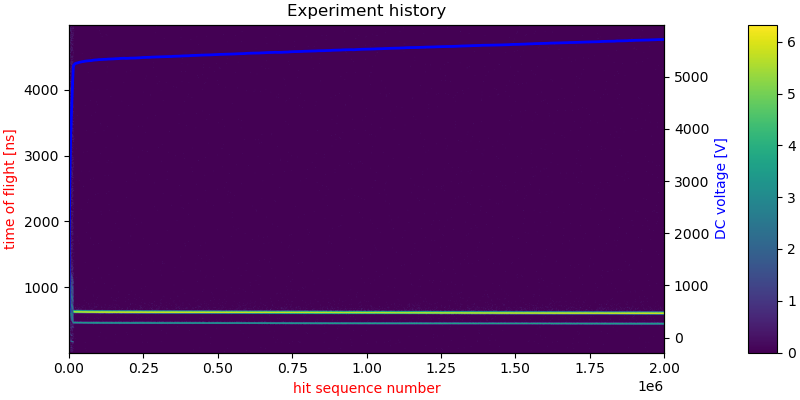

In [52]:
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, save_name = variables.result_path + '//ex_hist_' + dataset_name)

$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [53]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_group_storage)

Min Idx: 58126.42920392798 Max Idx: 1999567.89978656


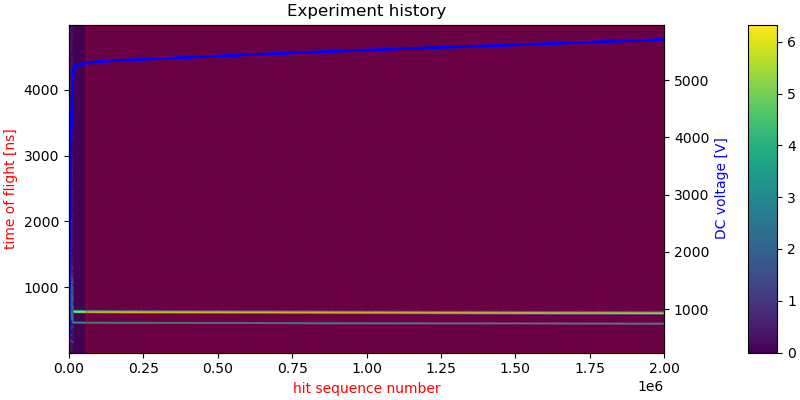

In [54]:
# Plot and selected experiment history
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

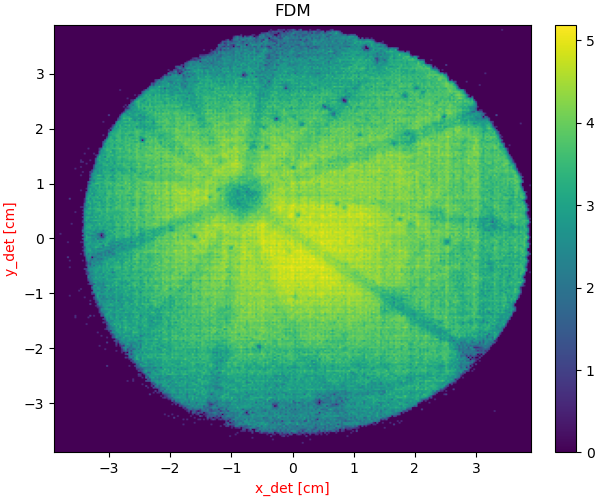

In [55]:
# Plot and select the FDM
data_loadcrop.plot_crop_FDM(data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

$\text {The region selected in the previous step is displayed below.}$

x: 0.24978825113199887 y: 0.10799306393544583 roi: 3.501548227627902


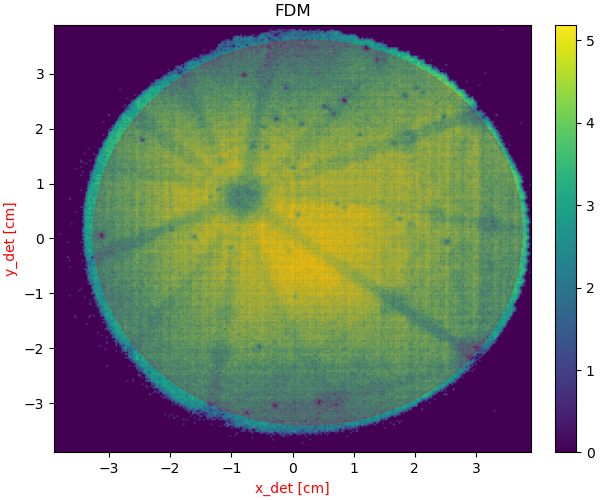

In [56]:
# plot selected area in FDM
data_loadcrop.plot_crop_FDM(data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name, circle=True)

$\text {The final selected data after processing is shown below.}$

d:\pyccapt\pyccapt\calibration\calibration_tools\data_loadcrop.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop.drop(np.where(mask_fdm)[0], inplace=True)


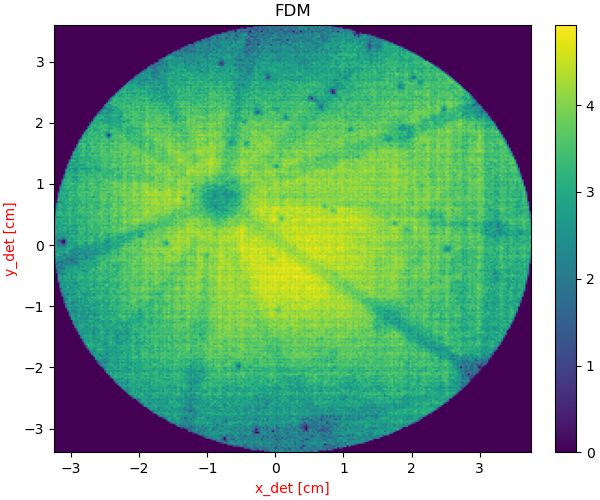

In [57]:
# Crop and plot the dataset
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_crop_FDM(data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name, only_plot=True)

In [58]:
# calculate Pulses since last event pulse and Ions per pulse
counter = data_crop_FDM['start_counter'].to_numpy()

pulse_pi = np.zeros(len(counter))
ion_pp = np.zeros(len(counter))
temp = counter[0]
multi_hit_count = 1
pulse_to_previous_ion = 0
for i in range(len(counter)):

    if i+2 > len(counter):
        ion_pp[i] = multi_hit_count
        pulse_pi[i] = counter[i] - counter[i-1]
    else:
        if temp == counter[i+1]:
            multi_hit_count = multi_hit_count + 1
        else:
            if i != 0:
                temp = counter[i-1]
                pulse_to_previous_ion = counter[i] - temp
            else:
                pulse_to_previous_ion = 0
            for j in range(multi_hit_count):
                if j == 0:
                    ion_pp[i+j] = multi_hit_count
                    pulse_pi[i+j] = pulse_to_previous_ion
                elif j != 0 or i == 0:
                    ion_pp[i+j] = 0
                    pulse_pi[i+j] = 0
            multi_hit_count = 1


# add two calculated array to the croped dataset
data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


C:\Users\APTUser\AppData\Local\Temp\ipykernel_18200\3416479450.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
C:\Users\APTUser\AppData\Local\Temp\ipykernel_18200\3416479450.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [59]:
# save the cropped data

print('tof Crop Loss {:.2f} %'.format(((1 - len(data_crop_FDM) / len(dld_group_storage)) * 100)))

tof Crop Loss 6.08 %


In [60]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data_crop_FDM['high_voltage (V)'].to_numpy()
if pulse_mode.value == 'voltage':
    dld_pulseVoltage = data_crop_FDM['pulse (V)'].to_numpy()
elif pulse_mode.value == 'laser':
    dld_pulseVoltage = data_crop_FDM['pulse (deg)'].to_numpy()
dld_t = data_crop_FDM['t (ns)'].to_numpy()
dld_x = data_crop_FDM['x_det (cm)'].to_numpy()
dld_y = data_crop_FDM['y_det (cm)'].to_numpy()

mc_seb_ini = mc_tools.tof2mc(dld_t, t0_d.value, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength_d.value, mode=pulse_mode.value)

data_crop_FDM.insert(0, 'x (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(1, 'y (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(2,'z (nm)', np.zeros(len(mc_seb_ini)))

data_crop_FDM.insert(3,'mc_c (Da)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(4, 'mc (Da)', mc_seb_ini)

data_crop_FDM.insert(9,'t_c (nm)', np.zeros(len(mc_seb_ini)))

In [61]:
# Remove the data with mc biger thatn 400
mask = (data_crop_FDM['mc (Da)'].to_numpy() > max_mc.value)
print('The number of data over max_mc:', len(mask[mask==True]))
data_crop_FDM.drop(np.where(mask)[0], inplace=True)
data_crop_FDM.reset_index(inplace=True, drop=True)

The number of data over max_mc: 27428


C:\Users\APTUser\AppData\Local\Temp\ipykernel_18200\2594199460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM.drop(np.where(mask)[0], inplace=True)


gggg 0.018355101934970804


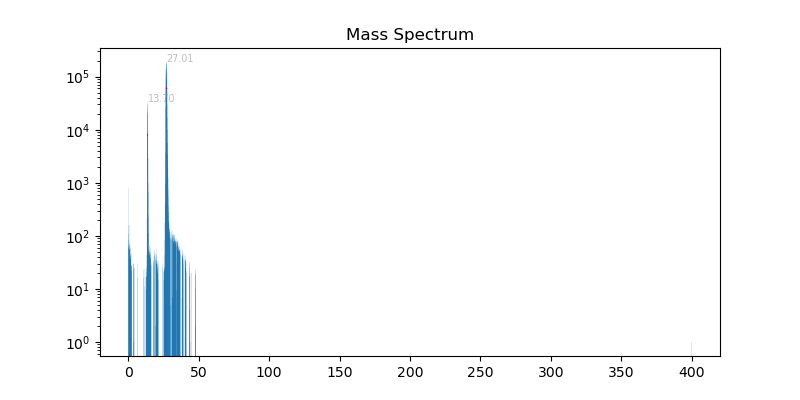

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 30.000001650923682
Peaks  0 is at location and height: (13.70, 32715.00) peak window sides (50.00%) are: (13.40, 13.90)
Peaks  1 is at location and height: (27.01, 188990.00) peak window sides (50.00%) are: (26.51, 27.41)


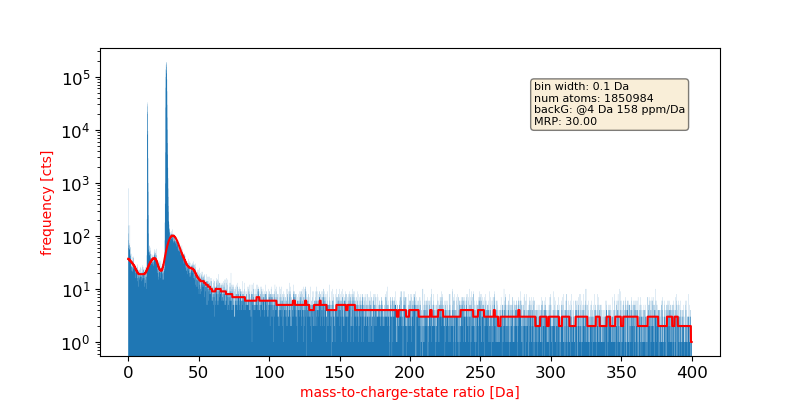

In [99]:
percent_mrp = 50
background = {'calculation': True, 'plot_no_back': True, 'plot': True, 'mode': 'fabc', 'patch': False, 'lam': 1e4, 'num_std': 7.0}
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(data_crop_FDM['mc (Da)'], 0.1, prominence=200, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, label='mc', fig_name='mc', background=background)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))
    

In [73]:
data_crop_FDM

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,26.924788,5297.891113,5297.891113,41471.0,623.227608,0.0,0.216490,-1.362612,0,1
1,0.0,0.0,0.0,0.0,27.120329,5297.891113,5297.891113,41591.0,625.586760,0.0,-0.904163,1.101551,120,1
2,0.0,0.0,0.0,0.0,26.525791,5297.891113,5297.891113,42439.0,619.229394,0.0,0.557143,-1.302122,848,1
3,0.0,0.0,0.0,0.0,13.773880,5297.891113,5297.891113,43141.0,470.863422,0.0,1.400816,2.425959,702,1
4,0.0,0.0,0.0,0.0,27.560995,5297.891113,5297.891113,43203.0,634.557024,0.0,0.149633,1.967510,62,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850979,0.0,0.0,0.0,0.0,26.736715,5710.552734,5710.552734,15857.0,602.687898,0.0,1.168408,-1.260735,740,1
1850980,0.0,0.0,0.0,0.0,34.632419,5710.552734,5710.552734,16295.0,689.050692,0.0,2.515102,0.929633,438,1
1850981,0.0,0.0,0.0,0.0,27.401981,5710.552734,5710.552734,16329.0,614.613960,0.0,-2.231755,0.528490,34,1
1850982,0.0,0.0,0.0,0.0,13.693572,5710.552734,5710.552734,16370.0,456.818238,0.0,-2.333633,-1.999347,41,1


In [31]:
data_crop_FDM.dtypes

x (nm)              float64
y (nm)              float64
z (nm)              float64
mc_c (Da)           float64
mc (Da)             float64
high_voltage (V)    float64
pulse (V)           float64
start_counter       float64
t (ns)              float64
t_c (nm)            float64
x_det (cm)          float64
y_det (cm)          float64
pulse_pi             uint32
ion_pp               uint32
dtype: object

In [32]:
# save the dataset to hdf5 file
hierarchyName = 'df'
data_tools.store_df_to_hdf(savename, data_crop_FDM, hierarchyName)

In [24]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.pos')

In [ ]:
# save data in csv format
data_tools.store_df_to_csv(data_crop_FDM, variables.result_path + dataset_name + '.csv')